In [1]:
%cd ../..

C:\Work\Modern Time Series Forecasting _ 2E\Modern-Time-Series-Forecasting-with-Python-2E


### Installing MLForecast (if not installed)

In [2]:
# %%capture
# !pip install -q mlforecast

### Common Imports

In [3]:
import numpy as np
import pandas as pd

### Common Functions and metrics

- The `plot_grid` auxiliary function defined below will be useful to plot different time series, and different models' forecasts.Importing it from `src/utils/plotting_utils.
- `average_length` isn't implemented in `utilsforecast`, and therefore we have implemented it the same way as the rest of the metrics. Importing it from `src/utils/ts_utils.py`.
- `level_to_quantiles` is a function that converts a level to a quantile. Importing it from `src/utils/ts_utils.py`.

In [4]:
from src.utils.ts_utils import average_length, level_to_quantiles
from src.utils.plotting_utils import plot_grid

### Loading M4 Data

Let's load the data and pick 8 time series to work with.

In [5]:
from src.utils.general import download_m4_data
import os
if not os.path.exists('data/m4/M4-Hourly.csv'):
    download_m4_data()
Y_train_df = pd.read_csv('data/m4/M4-Hourly.csv')
Y_test_df = pd.read_csv('data/m4/M4-Hourly-test.csv')#.rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long.

In [6]:
# Taking first n_series time series from the dataset
n_series = 8
uids = Y_train_df['unique_id'].unique()[:n_series]
Y_train_df = Y_train_df.query('unique_id in @uids')
Y_test_df = Y_test_df.query('unique_id in @uids')

### Plotting Sampled TS

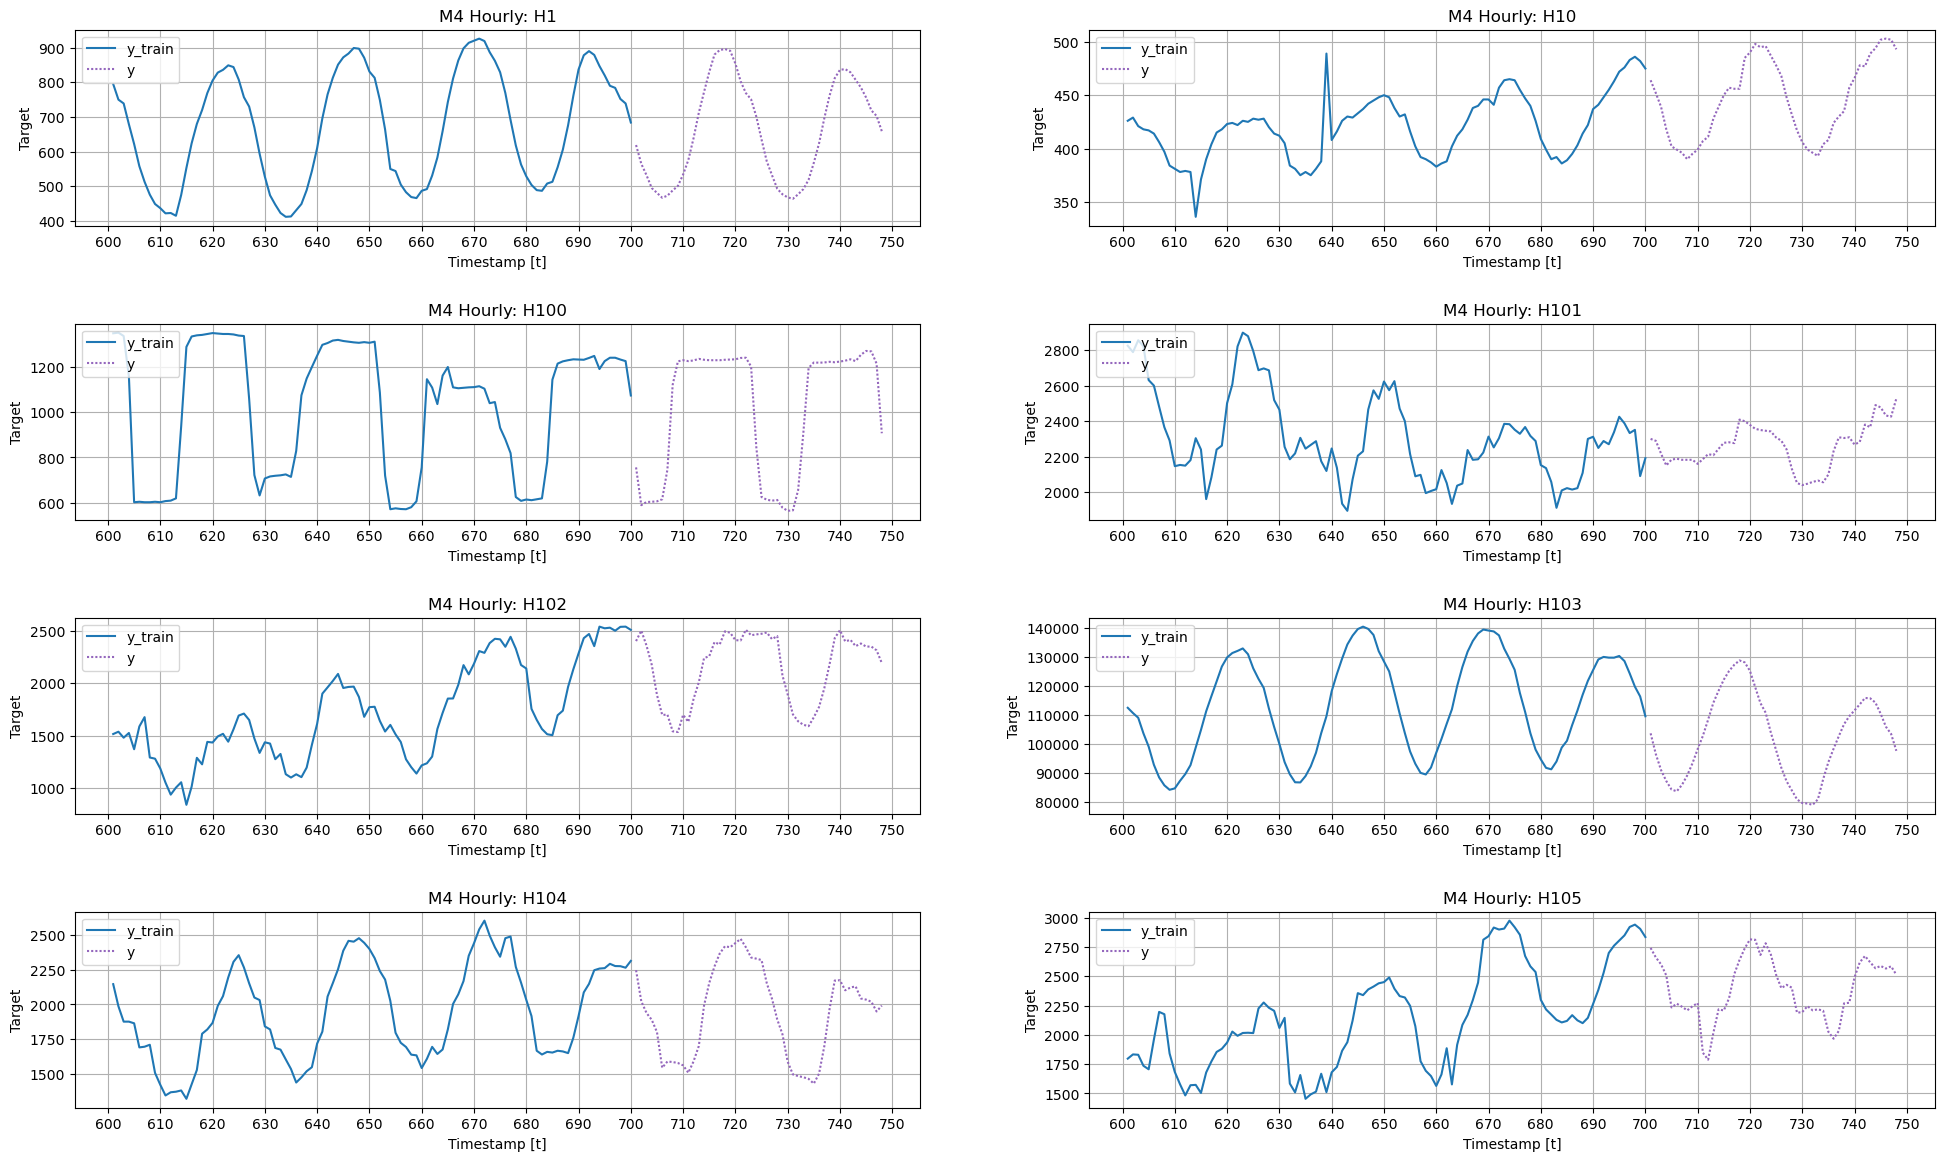

In [7]:
# Plotting the selected time series
plot_grid(Y_train_df, Y_test_df)

### Adding a few features we learned to make this into a regression problem

In [8]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, ExpandingMean, Offset

In [9]:
data = pd.concat([Y_train_df, Y_test_df], ignore_index=True)

In [10]:
fcst = MLForecast(
    models=[],
    freq=24,
    lags=[1,2,3,4, 7], # Defining the Lags we need to create
    # Defining some transformations we need to do to the lags (offsets)
    lag_transforms={
        1: [ExpandingMean(), RollingMean(window_size=7, min_samples=1), RollingMean(window_size=14)],
    },
)
data = fcst.preprocess(data)
data.head()

,unique_id,ds,y,lag1,lag2,lag3,lag4,lag7,expanding_mean_lag1,rolling_mean_lag1_window_size7_min_samples1,rolling_mean_lag1_window_size14
14,H1,15,493.0,455.0,420.0,397.0,383.0,395.0,465.285714,400.285714,465.285714
15,H1,16,554.0,493.0,455.0,420.0,397.0,382.0,467.133333,414.285714,457.285714
16,H1,17,610.0,554.0,493.0,455.0,420.0,370.0,472.562500,438.857143,455.000000
17,H1,18,666.0,610.0,554.0,493.0,455.0,383.0,480.647059,473.142857,456.714286
18,H1,19,715.0,666.0,610.0,554.0,493.0,397.0,490.944444,513.571429,464.357143


### LightGBM

Let's see how we can use LightGBM and its Quantile REgression to get probabilistic forecast. The same can be done with other leading implementations like XGBoost and CatBoost but the syntax may slightly vary.

In [11]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [12]:
# Splitting Train and Val after feature engineering
val_dates = Y_test_df.ds.unique()

train = data[~data['ds'].isin(val_dates)]
val = data[data['ds'].isin(val_dates)]
train_keys = train[["unique_id", 'ds']]
val_keys = val[["unique_id", 'ds']]
train = train.drop(['unique_id', 'ds'], axis=1)
val = val.drop(['unique_id', 'ds'], axis=1)
X_train, Y_train = train.drop(['y'], axis=1), train['y']
X_val, Y_val = val.drop(['y'], axis=1), val['y']

#### Training

For using LightGBM

In [13]:
params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'max_depth': 4,
    'num_leaves': 15,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'boosting_type': 'gbdt'
}

levels = [80, 90]
# converting levels to quantiles
# For 90% Confidence - 0.1 for lower, 0.5 for median, and 0.9 for upper
quantiles = [0.5] + sum([level_to_quantiles(l) for l in levels], [])
quantiles

[0.5, 0.1, 0.9, 0.05, 0.95]

In [14]:
# Training a model each for the quantiles
quantile_models = {}
for q in quantiles:
    model = LGBMRegressor(alpha=q, **params)
    model = model.fit(X_train, Y_train)
    quantile_models[q] = model

## Inference

In [15]:
# Point Forecast using the 0.5 quantile model
y_pred = quantile_models[0.5].predict(X_val)
y_pred[:10]

array([678.89273491, 618.9026785 , 581.3320878 , 554.03383023,
       531.23680849, 529.91707515, 512.30483125, 536.77885592,
       565.88594604, 517.40007455])

In [16]:
# Prediction Intervals using the 0.1 and 0.9 quantile models
y_pred_lower = quantile_models[0.1].predict(X_val)
y_pred_upper = quantile_models[0.9].predict(X_val)

Generating predictions and assigning them back to standard format

In [17]:
# Point Forecast
Y_test_df['LGBM'] = quantile_models[0.5].predict(X_val)

for l in levels:
    lo, hi = level_to_quantiles(l)
    # Prediction Interval with confidence
    Y_test_df[f'LGBM-lo-{l}'] = quantile_models[lo].predict(X_val)
    Y_test_df[f'LGBM-hi-{l}'] = quantile_models[hi].predict(X_val)
Y_test_df.head()

,unique_id,ds,y,LGBM,LGBM-lo-80,LGBM-hi-80,LGBM-lo-90,LGBM-hi-90
0,H1,701,619.0,678.892735,604.905076,782.859175,589.858967,931.397023
1,H1,702,565.0,618.902679,561.499442,803.220477,553.385419,931.397023
2,H1,703,532.0,581.332088,487.849582,789.264699,467.555807,931.397023
3,H1,704,495.0,554.033830,478.672479,785.666019,469.192146,931.397023
4,H1,705,481.0,531.236808,482.358675,785.892285,467.690515,931.397023


#### Plotting

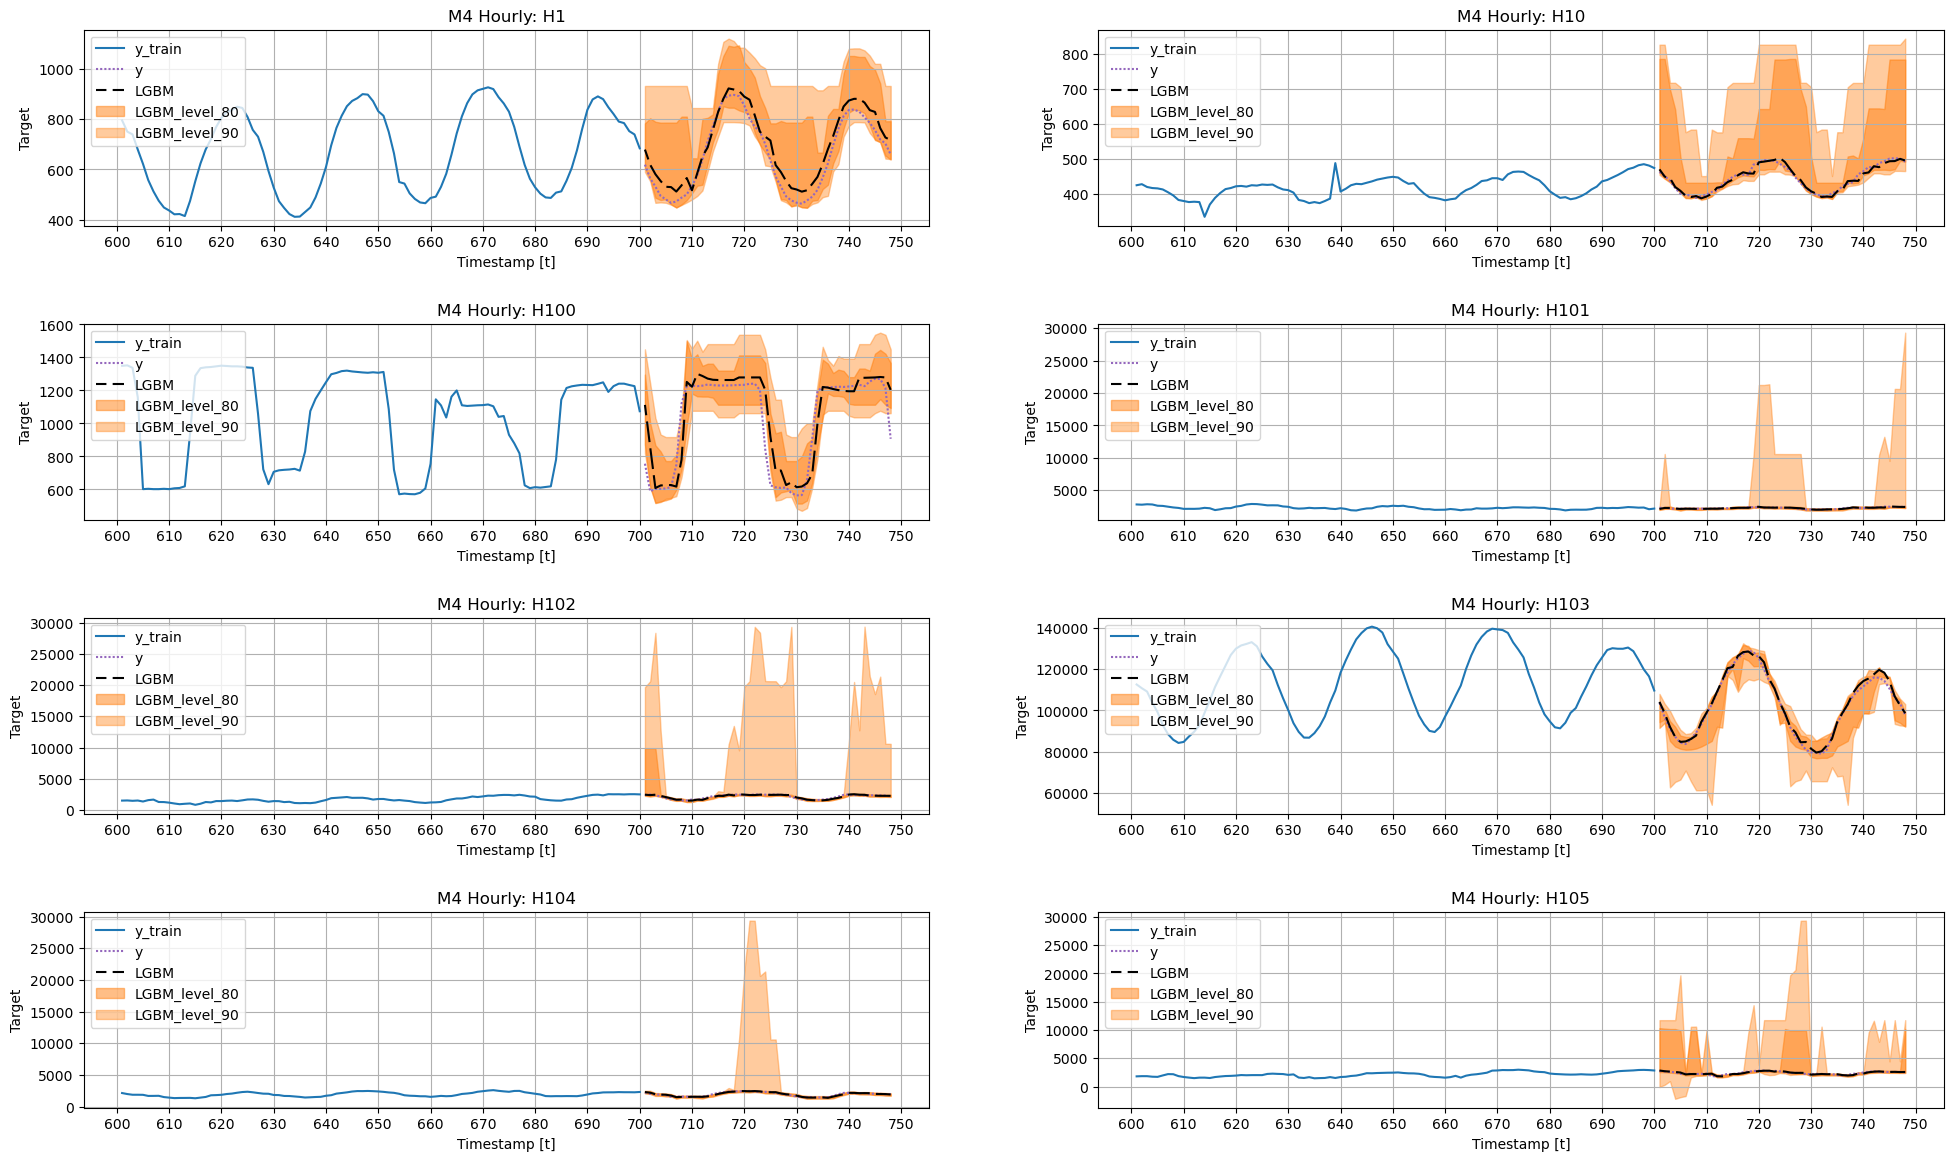

In [18]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='LGBM')

#### Metrics

In [19]:
from utilsforecast.losses import mae, coverage

In [20]:
res_df = mae(Y_test_df, models=['LGBM']).rename(columns={'LGBM': 'LGBM-mae'})
for l in levels:
    res_df = res_df.merge(coverage(Y_test_df, models=['LGBM'], level=l).rename(columns={'LGBM': f'LGBM-coverage-{l}'}), on='unique_id')
    res_df = res_df.merge(average_length(Y_test_df, models=['LGBM'], level=l).rename(columns={'LGBM': f'LGBM-average_length-{l}'}), on='unique_id')
res_df

,unique_id,LGBM-mae,LGBM-coverage-80,LGBM-average_length-80,LGBM-coverage-90,LGBM-average_length-90
0,H1,42.003218,0.895833,237.391189,1.000000,365.452160
1,H10,6.378531,0.812500,151.917693,0.895833,280.675432
2,H100,80.271020,0.812500,262.200214,0.875000,439.862966
3,H101,43.714527,0.958333,249.450173,1.000000,4679.752953
4,H102,98.038727,0.729167,738.286167,0.875000,9401.480156
5,H103,1277.223668,0.833333,10382.047638,0.979167,20295.171957
6,H104,72.351522,0.875000,288.520722,0.916667,3171.172246
7,H105,92.217800,0.666667,2458.989914,0.895833,6652.189939
